In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sin
%matplotlib inline

# ==========================================================
# Задача на МНК (0.4 балла)

In [ ]:
''' Пусть физический закон описывается зависимостью 
    некоторого измеряемого значения y(x, a) 
    от времени и координаты x при параметрах a:
'''

def y(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]

In [ ]:
''' Дан набор координат t размера m, значения распределены равномерно. 
    Пусть m = 200.
'''

m = 200
t = [i * 10.0 / m for i in range(m)]

In [ ]:
''' Для каждого момента времени t сгенерируйте соответствующее
    значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера:
'''

a = [10, 100, 1000]

In [ ]:
''' Результаты измерений отличаются от истинных значений 
    в силу действия случайной аддитивной помехи
    (случайность подчиняется нормальному закону распределения N(0, σ))
'''

def get_y(a, σ):
    y_real = np.array([y(i, a) for i in t])
    y_corr = y_real + np.random.normal(0, σ, m)
    
    return y_real, y_corr

In [ ]:
''' Выберем параметр σ.
'''

σ = 0.5

In [ ]:
''' Сгенерируем значения: исходные и с помехами.
'''

y_real, y_corr= get_y(a, σ)

In [ ]:
''' По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    1) method = 0 -> сумма квадратов невязок будет минимальна;
    2) method = 1 -> сумма абсолютных значений невязок будет минимальна;
    3) method = 2 -> максимальное абсолютное значение невязки будет минимально.
'''

def get_params (y_corr, t, method=0):
    return [0,0,0]

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [2]:
def isoptimal(zstar):
    for z in zstar:
        if (z < 0):
            return False
    return True

In [3]:
def getenteringindex(size, zstar, nonbasic):
    index = size + 1
    for i in range(len(zstar)):
        if zstar[i] < 0 and nonbasic[i] < index:
            index = i + 1
    return index

In [4]:
def getleavingindex(size, primalstepdirection, xstar, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    index = size + 1
    for i in range(len(xstar)):
        if values[i] == value and basic[i] < index:
            index = i
    return (1 / values[index]), index + 1

In [5]:
def lexical(primalstepdirection, xstar, N, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    rows = []
    indexes = []
    for i in range(len(xstar)):
        if values[i] == value:
            row = [xstar[i] / basic[i]]
            row += list(N[i] / (-basic[i]))
            rows += [row]
            indexes += [i]
    index = np.argmin(rows, axis=0)[0]
    return (1 / value), indexes[index] + 1

In [6]:
def changebasis(basic, nonbasic,
                enteringindex, leavingindex):
    temp = basic[leavingindex - 1]
    basic[leavingindex - 1] = nonbasic[enteringindex - 1]
    nonbasic[enteringindex - 1] = temp

In [7]:
def changematrix(B, N,
                 enteringindex, leavingindex):
    temp = B[:, leavingindex - 1].copy()
    B[:, leavingindex - 1] = N[:, enteringindex - 1]
    N[:, enteringindex - 1] = temp

In [8]:
def solution(n, m, c, basic, nonbasic, xstar):
    answer = np.zeros(n + m)
    answer[basic - 1] = xstar
    answer[nonbasic - 1] = 0
    return answer[:n], c @ (answer[:n]).T

In [9]:
def getpoint(n, m, xstar, basic, nonbasic):
    values = np.zeros(n + m)
    values[basic - 1] = xstar
    values[nonbasic - 1] = 0
    return list(values[:n])

In [10]:
def ok(A, b, x, y):
    vector = np.array([x, y])
    values = A @ vector.T
    for i in range(len(values)):
        if values[i] > b[i]:
            return False
    return True

In [11]:
def getpoints(a, b):
    y = 0
    x = 0
    other = []
    if a[1] != 0:
        y = b / a[1]
    if a[0] != 0:
        x = b / a[0]
    if x > 0 and y > 0:
        other = [[0, y], [x, 0]]
    elif x > 0 and y < 0:
        other = [[x, 0], [10 * x, (b - a[0] * 10 * x) / a[1]]]
    elif y > 0 and x < 0:
        other = [[0, y], [(b - a[1] * 10 * y) / a[0], 10 * y]]
    elif y == 0 and x > 0:
        other = [[x, 0], [x, 10]]
    elif x == 0 and y > 0:
        other = [[0, y], [10, y]]
    return other

In [12]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

In [17]:
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return 0, 0

In [76]:
def auxiliary(A, b):
    n = A.shape[1]
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(0, n + 1)
    xstar = b.copy()
    zstar = [-1] + [0] * n
    B = np.eye(m)
    N = np.c_[-np.ones(m), A.copy()]

    #TODO
    #pivot
    leavingindex = np.argmin(xstar)
    changebasis(basic, nonbasic, 1, leavingindex + 1)
    #pivot
    #TODO
    
    while True:
        if (isoptimal(xstar)):
            break
        else:
            #TODO: primal simplex method with max coefficient
            enteringindex = 0
            vector = np.eye(n + 1)[enteringindex]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            t = np.min(xstar)
            leavingindex = np.argmin(xstar)
            vector = np.eye(m)[leavingindex]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex] / dualstepdirection[enteringindex]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex] = s
            xstar[leavingindex] = t
            changebasis(basic, nonbasic,
                        enteringindex + 1, leavingindex + 1)
            changematrix(B, N, enteringindex + 1,
                         leavingindex + 1)
            break

In [77]:
A = np.array([[2, -1, 2], [2, -3, 1], [-1, 1, -2]])
b = np.array([4, -5, -1])
auxiliary(A, b)

In [13]:
def simplex(n, A, b, c, method='bland', start_point=None, draw=False):
    supplement = 0
    if start_point != None:
        b = b - A @ start_point.T
        supplement = c @ start_point.T
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(1, n + 1)
    xstar = b.copy()
    zstar = -(c.copy())
    B = np.eye(m)
    N = A.copy()
    iteration = 0
    points = [[0, 0]]
    while True:
        if (isoptimal(zstar)):
            point, value = solution(n, m, c, basic, nonbasic, xstar)
            if start_point != None:
                value += supplement
                point += start_point
            if draw and n == 2:
                points = np.array(points)
                if start_point != None:
                    points += start_point
                    b = b + A @ start_point.T
                for i in range(iteration + 1):
                    xmin = -0.1
                    xmax = -1
                    ymin = -0.1
                    ymax = -1
                    plt.plot([0, 10], [0, 0], c='blue', alpha=0.2)
                    plt.plot([0, 0], [0, 10], c='blue', alpha=0.2)
                    if ok(A, b, 0, 0):
                        plt.scatter(0, 0, c='black')
                    for j in range(m):
                        y = 0
                        x = 0
                        dots = []
                        if A[j][1] != 0:
                            y = b[j] / A[j][1]
                        if A[j][0] != 0:
                            x = b[j] / A[j][0]
                        if x > 0 and y > 0:
                            plt.plot([0, x], [y, 0], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[0, y], [x, 0]]
                        elif x > 0 and y < 0:
                            plt.plot([x, 10 * x], [0, (b[j] - A[j][0] * 10 * x) / A[j][1]], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [10 * x, (b[j] - A[j][0] * 10 * x) / A[j][1]]]
                        elif y > 0 and x < 0:
                            plt.plot([0, (b[j] - A[j][1] * 10 * y) / A[j][0]], [y, 10 * y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [(b[j] - A[j][1] * 10 * y) / A[j][0], 10 * y]]
                        elif y == 0 and x > 0:
                            plt.plot([x, x], [0, 10], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [x, 10]]
                        elif x == 0 and y > 0:
                            plt.plot([0, 10], [y, y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [10, y]]
                        for k in range(m):    
                            if k == j:
                                continue
                            else:
                                L1 = line(dots[0], dots[1])
                                dots = getpoints(A[k], b[k])
                                L2 = line(dots[0], dots[1])
                                x, y = intersection(L1, L2)
                                if ok(A, b, x, y):
                                    plt.scatter(x, y, c='black')
                                    if y > ymax:
                                        ymax = y
                                    if x > xmax:
                                        xmax = x
                    plt.scatter(points[i][0], points[i][1], c='red')
                    plt.xlim((xmin, xmax + 1))
                    plt.ylim((ymin, ymax + 1))
                    plt.title('iteration = %d; point = (%.2f, %.2f)' % (i, points[i][0], points[i][1]))
                    plt.show()
            return value, point, iteration
            break
        else:
            iteration += 1
            enteringindex = getenteringindex(n + m, zstar, nonbasic)
            vector = np.eye(n)[enteringindex - 1]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            t = 0
            leavingindex = 0
            if method == 'bland':
                t, leavingindex = getleavingindex(n + m, primalstepdirection, xstar, basic)
            elif method == 'lexical':
                t, leavingindex = lexical(primalstepdirection, xstar, N, basic)
            vector = np.eye(m)[leavingindex - 1]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex - 1] / dualstepdirection[enteringindex - 1]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex - 1] = s
            xstar[leavingindex - 1] = t
            changebasis(basic, nonbasic,
                        enteringindex, leavingindex)
            changematrix(B, N,
                         enteringindex, leavingindex)
            if draw and n == 2:
                points += [getpoint(n, m, xstar, basic, nonbasic)]

In [14]:
def checkoptimal(A, b, c, x):
    value, point, iteration = simplex(A.shape[1], A, b, c)
    return np.array_equal(point, x)

## Тесты

In [14]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
x = np.array([4, 5])
checkoptimal(A, b, c, x)

True

In [24]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, method='lexical', start_point=start_point)

Значение целевой функции:  31.0
Оптимальная точка:  [ 4.  5.]
Число итераций:  3


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


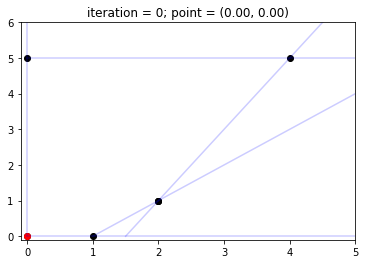

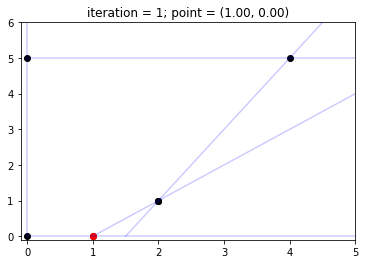

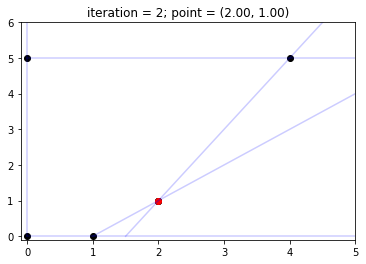

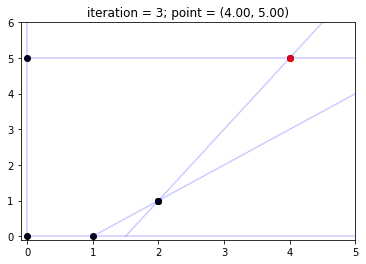

(31.0, array([ 4.,  5.]), 3)

In [67]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
simplex(2, A, b, c, draw=True)

In [14]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, start_point=start_point)

Значение целевой функции:  31.0
Оптимальная точка:  [ 4.  5.]
Число итераций:  3


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


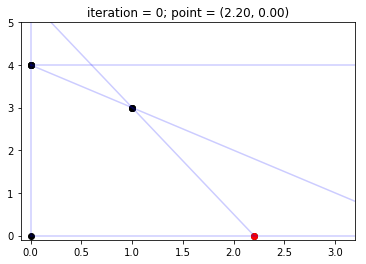

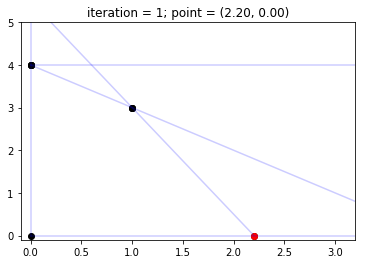

(22.0, array([ 2.2,  0. ]), 1)

In [16]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, method='lexical', start_point=start_point, draw=True)

In [16]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
simplex(2, A, b, c)

A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, start_point=start_point)

Значение целевой функции:  22.0
Оптимальная точка:  [ 2.2  0. ]
Число итераций:  1
Значение целевой функции:  22.0
Оптимальная точка:  [ 2.2  0. ]
Число итераций:  1


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [17]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

Значение целевой функции:  1.0
Оптимальная точка:  [ 1.  0.  1.  0.]
Число итераций:  5


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


In [18]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
simplex(4, A, b, c)

A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, start_point=start_point)

Значение целевой функции:  1.0
Оптимальная точка:  [ 1.  0.  1.  0.]
Число итераций:  5
Значение целевой функции:  1.0
Оптимальная точка:  [ 1.  0.  1.  0.]
Число итераций:  2


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [19]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
simplex(4, A, b, c)

A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, start_point=start_point)

Значение целевой функции:  7.0
Оптимальная точка:  [ 0.  1.  0.  0.]
Число итераций:  1
Значение целевой функции:  7.0
Оптимальная точка:  [ 0.  1.  0.  0.]
Число итераций:  1


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [26]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

Значение целевой функции:  7.0
Оптимальная точка:  [ 0.  1.  0.  0.]
Число итераций:  1


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [31]:
import numpy as np
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <= с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    x=np.array([4,0])
    result=20
    num_iter=1
    
    #тут рисуем анимацию
    if draw:
        fig, ax= plt.subplots(num_iter+1)
        fig.set_figheight(5*(num_iter+1))
        fig.set_figwidth(5)
        xs=[[0,0],[4,0]]

        for i,a in enumerate(ax):
            a.plot([0,5],[5,0],  color='b')
            a.plot([4,0],[0,16], color='b')
            a.plot([0,0],[0,5], color='b')
            a.plot([0,4],[0,0], color='b')
            a.axis([-1, 17, -1, 17])
            a.set_xlabel('X1')
            a.set_ylabel('X2')
            a.set_title('Iteration %d x=(%.2f, %.2f)' % (i+1,xs[i][0],xs[i][1]))

        ax[0].scatter([0,4,3.66],[5,0,1.33], color='black')
        ax[0].scatter([0],[0], color='red')

        ax[1].scatter([0,0,3.66],[0,5,1.33], color='black')
        ax[1].scatter([4],[0], color='red')


        plt.tight_layout()
        plt.show()
    
    return np.array([4,0]), 20, 1

def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    return (x==np.array([4,0])).all()

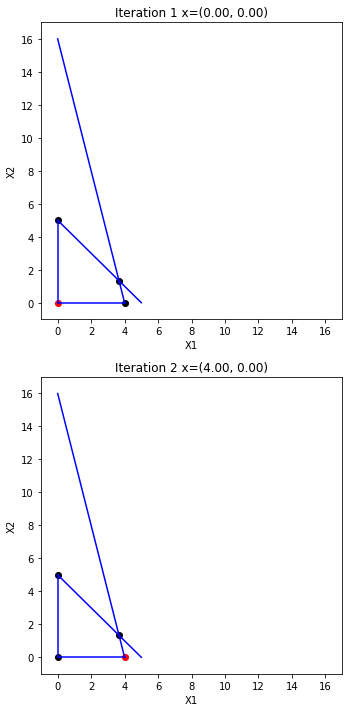

In [32]:
x, best, n_iter = solve_lin_prog(A,b,c, draw=True)

In [ ]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

In [ ]:
is_optimal(A,b,c,x)

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)